# Code for fig3

In [1]:
## imports (generic)
import os
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular' # to use latex math symbols like mu

## Prepare inputs

In [2]:
## input data from peat_exp_analysis/v25, copied in folder ../data
path_data = '../data'
## set path for storing the figure made by this file
path_fig = '../fig'

In [14]:
# read in the data - result from experiment v14
## OSCAR output - ssp scenarios
TMP = xr.open_dataset(path_data + '/OUT_cut_scen_tier2_peat_calc_stat_drop.nc')
ds_calc_tier2 = TMP.copy(deep=True) 

TMP = xr.open_dataset(path_data + '/OUT_cut_scen_peat_calc_stat.nc')
ds_calc_ssp = TMP.copy(deep=True) 


In [16]:
folder_data = path_data
## mask to filter out negative scenarios from input
TMP = xr.open_dataset(folder_data + '/ds_subset_mask.nc')
ds_eff_mask = TMP.copy(deep=True)
## mask to filter out negative scenarios from output
TMP = xr.open_dataset(folder_data + '/ds_dco2_mask.nc')
ds_dco2_mask = TMP.copy(deep=True)
## non-overshoot related calculations
TMP = xr.open_dataset(folder_data + '/ds_calc_nov.nc')
ds_calc_nov = TMP.copy(deep=True)
TMP = xr.open_dataset(folder_data + '/ds_calc_nov_pt.nc')
ds_calc_nov_pt = TMP.copy(deep=True)
TMP = xr.open_dataset(folder_data + '/ds_calc_nov_pt_obelix.nc')
ds_calc_nov_pt_obelix = TMP.copy(deep=True)
# make a mask for selecting non-extreme values
mask_scen = ds_dco2_mask['mask_dco2'].drop(['year','var_name'])
mask_tg = ds_calc_nov_pt['best_guess'].sel(var_name='D_Tg') <= 200
mask_co2 = ds_calc_nov_pt['best_guess'].sel(var_name='D_CO2') <= 3000
mask_ept_co2 = ds_calc_nov_pt_obelix['best_guess'].sel(var_name='D_Ept_CO2') <= 0.07

# Combine the masks using logical OR to check if any criteria is met along the 'scen' dimension, including all four masks above
combined_mask = ~((~mask_tg).any(dim='year') & (~mask_co2).any(dim='year') & (~mask_ept_co2).any(dim='year')).drop('var_name')
combined_mask = combined_mask.where(mask_scen, drop=True)

##  define function to plot

In [37]:
def fig2_plt(ds, targetT, var_C, var_T, scen, lab):
    # the function to make a plot between cumulative CH4/CO2 and Tpeak/cum_T
    # var_C can be 'cum_abs_Ept_CO2' or 'cum_abs_Ept_CH4' or deltaC
    # var_T can be 'peakT' or 'cumT'
    # scen can be 'SSP', 'Tier1', or 'PROVIDE'
    # lab can be 'shp', 'colr','none'
    ds_target = ds[['Tpeak_bg','Tpeak_per','best_guess_cum','per_weighted_cum','cumT_bg','cumT_per']].where(ds.ov_msk_bg.sel(target_T=targetT))
    if var_T == 'peakT':
        if var_C != 'deltaC':
            # mean values for x and y
            x = ds_target.Tpeak_bg
            y = ds_target.best_guess_cum.sel(var_name_cum = var_C).drop('var_name_cum')
            #print('x and y loaded')
            #percentile values for x and y
            for per in [16]:
                ds_per = ds_target
                x_lower_error = x - ds_per.Tpeak_per.sel(percentile = per)
                x_upper_error = ds_per.Tpeak_per.sel(percentile = 100-per) - x

                y_lower_error = y - ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = per)
                y_upper_error = ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = 100-per) - y

                asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                asymmetric_error_y = ([y_lower_error.values, y_upper_error.values]) if 'CO2' in var_C else ([y_lower_error.values/1000, y_upper_error.values/1000])

                plt.errorbar(x, y if 'CO2' in var_C else y/1000, 
                            xerr = asymmetric_error_x, yerr = asymmetric_error_y, linewidth=0.7,
                            fmt='D' if scen =='SSP' else 'o',  markerfacecolor='none' if scen =='PROVIDE' else col_targetT[targetT], 
                            color = col_targetT[targetT], capsize = 0, alpha = 0.2 if scen == 'PROVIDE' else 0.8,
                            label = '68% confidence interval' if targetT == 1.5 and lab == 'colr' else '')
                #print('error bar plotted')
        else:
            # mean values for x and y
            x = ds_target.Tpeak_bg
            y = ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum')+ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum')/1000
            #print('x and y loaded')
            #percentile values for x and y
            for per in [16]:
                ds_per = ds_target
                x_lower_error = x - ds_per.Tpeak_per.sel(percentile = per)
                x_upper_error = ds_per.Tpeak_per.sel(percentile = 100-per) - x

                y_lower_error = y - (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = per)+ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum').sel(percentile = per)/1000)
                y_upper_error = (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = 100-per)+ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum').sel(percentile = 100-per)/1000) - y

                asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                asymmetric_error_y = [y_upper_error.values, y_lower_error.values]

                plt.errorbar(x, -y, 
                            xerr = asymmetric_error_x, yerr = asymmetric_error_y, linewidth=0.7,
                            fmt='D' if scen =='SSP' else 'o',  markerfacecolor='none' if scen =='PROVIDE' else col_targetT[targetT], 
                            color = col_targetT[targetT], capsize = 0, alpha = 0.2 if scen == 'PROVIDE' else 0.8,
                            label = '68% confidence interval' if targetT == 1.5 and lab == 'colr' else '')
                #print('error bar plotted')

    elif var_T == 'cumT':
        if var_C != 'deltaC':
            # mean values for x and y
            x = ds_target.cumT_bg.sel(target_T = targetT)
            y = ds_target.best_guess_cum.sel(var_name_cum = var_C).drop('var_name_cum')
            #percentile values for x and y
            for per in [16]:
                ds_per = ds_target
                x_lower_error = x - ds_per.cumT_per.sel(percentile = per, target_T = targetT)
                x_upper_error = ds_per.cumT_per.sel(percentile = 100-per, target_T = targetT) - x

                y_lower_error = y - ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = per)
                y_upper_error = ds_per.per_weighted_cum.sel(var_name_cum = var_C).drop('var_name_cum').sel(percentile = 100-per) - y

                asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                asymmetric_error_y = ([y_lower_error.values, y_upper_error.values]) if 'CO2' in var_C else ([y_lower_error.values/1000, y_upper_error.values/1000])
                plt.errorbar(x, y if 'CO2' in var_C else y/1000, 
                            xerr = asymmetric_error_x, yerr = asymmetric_error_y, linewidth=0.7,
                            fmt='D' if scen =='SSP' else 'o', markerfacecolor='none' if scen =='PROVIDE' else col_targetT[targetT], 
                            color = col_targetT[targetT], capsize = 0, alpha = 0.2 if scen == 'PROVIDE' else 0.8,
                            label = '68% confidence interval' if targetT == 1.5 and lab == 'colr' else '')
        else:
            # mean values for x and y
            x = ds_target.cumT_bg.sel(target_T = targetT)
            y = ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum')+ds_target.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum')/1000
            #percentile values for x and y
            for per in [16]:
                ds_per = ds_target
                x_lower_error = x - ds_per.cumT_per.sel(percentile = per, target_T = targetT)
                x_upper_error = ds_per.cumT_per.sel(percentile = 100-per, target_T = targetT) - x

                y_lower_error = y - (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = per)+ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').drop('var_name_cum').sel(percentile = per)/1000)
                y_upper_error = (ds_per.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').drop('var_name_cum').sel(percentile = 100-per)+ds_per.per_weighted_cum.sel(var_name_cum = "cum_abs_Ept_CH4").drop('var_name_cum').sel(percentile = 100-per)/1000) - y

                asymmetric_error_x = [x_lower_error.values, x_upper_error.values]
                asymmetric_error_y = [y_upper_error.values, y_lower_error.values]
                plt.errorbar(x, -y, 
                            xerr = asymmetric_error_x, yerr = asymmetric_error_y, linewidth=0.7,
                            fmt='D' if scen =='SSP' else 'o', markerfacecolor='none' if scen =='PROVIDE' else col_targetT[targetT], 
                            color = col_targetT[targetT], capsize = 0, alpha = 0.2 if scen == 'PROVIDE' else 0.8,
                            label = '68% confidence interval' if targetT == 1.5 and lab == 'colr' else '')
    else:
        print('Wrong Input')

    plt.scatter(x, y if 'CO2' in var_C else (y/1000 if 'CH4' in var_C else -y), 
                facecolors='none' if scen =='PROVIDE' else col_targetT[targetT], edgecolor = col_targetT[targetT], 
                marker ='D' if scen =='SSP' else 'o', alpha = 0.8 if scen =='PROVIDE' else 1.0, 
                label = f"GWL overshooting {targetT}\u00B0C" if lab == 'colr' else scen if targetT == 1.5 and lab == 'shp' else '')

## color choices

In [18]:
col = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffcc88','#ff9857', '#e77b2e', '#ffbcaf', '#f4777f', '#cf3759', '#93003a']
col_targetT = {1.5:'#4771b2',
               2.: '#a5d5d8', 
               2.5: '#ff9857', 
               3.0: '#cf3759'} 

col_txt = 'black'
col_txt_dsk = {1.5:'#00429d', 
               2.: '#73a2c6', 
               2.5: '#e77b2e', 
               3.0: '#93003a'}

## Make subplots

### plot 1

In [20]:
## filter out ds_calc with combined_mask
ds_calc = ds_calc_tier2.copy(deep=True)
ds_calc = ds_calc.where(combined_mask, drop=True)
tgt_lst = [1.5,2,2.5]

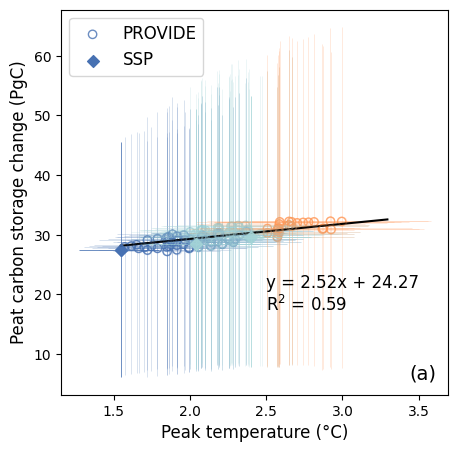

In [22]:
plt.figure(figsize=(5.,5.))
for targetT in tgt_lst:
    fig2_plt(ds_calc, targetT,'deltaC','peakT', 'PROVIDE','shp')
# plot tier1
#for targetT in ds_calc.target_T.values:
    #fig2_plt(ds_calc_tier1, targetT,'cum_abs_Ept_CO2','peakT', 'Tier1','shp')
# plot ssp
for targetT in tgt_lst:
    fig2_plt(ds_calc_ssp, targetT,'deltaC','peakT', 'SSP','shp')

# Linear regression line  ----------------- start --------------------
ds_plt = xr.merge([ds_calc[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']],ds_calc_ssp[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']]])
# find the scenarios where ov_msk_bg is 0 for all target_T values
ov_sum = ds_plt.ov_msk_bg.sum(dim='target_T')
valid_scen = ov_sum.where(ov_sum > 0, drop=True).scen.values
# create a new dataarray x_data that contains only Tpeak_bg for the valid scenarios
x_data = ds_plt.Tpeak_bg.sel(scen=valid_scen)
y_data = -(ds_plt.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').sel(scen=valid_scen) + ds_plt.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').sel(scen=valid_scen)/1000)
# remove NaN and inf values from x and y
valid = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data) | (x_data >= 1e10))
x = x_data[valid]
y = y_data[valid]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
x_values = np.linspace(x.min(), x.max(), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color=col_txt)
# R-squared and equation
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = f'R$^2$ = {r_value**2:.2f}'
# add the text to the plot
#plt.text(0.1, 0.85, f'{equation}\n{r_squared}', fontsize=12, 
         #ha='left', va='center', color='r', transform=plt.transAxes, zorder=10)
plt.text(2.5, 20., f'{equation}\n{r_squared}', fontsize=12, ha='left', va='center', color=col_txt, zorder=10)
# Linear regression line ---------------- end -------------------

plt.legend(fontsize = 12, loc = 'upper left')
plt.text(0.9, 0.08, "(a)", transform=plt.gca().transAxes, fontsize = 14,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Peat carbon storage change (PgC)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig3_Tpeak_cumC.png', dpi=300, bbox_inches='tight')

In [23]:
## calculate the uncertainty for the slope
# 16th 
ds_plt = xr.merge([ds_calc[['Tpeak_bg','cumT_bg','per_weighted_cum','ov_msk_bg']],ds_calc_ssp[['Tpeak_bg','cumT_bg','per_weighted_cum','ov_msk_bg']]])
# find the scenarios where ov_msk_bg is 0 for all target_T values
ov_sum = ds_plt.ov_msk_bg.sum(dim='target_T')
valid_scen = ov_sum.where(ov_sum > 0, drop=True).scen.values
# create a new dataarray x_data that contains only Tpeak_bg for the valid scenarios
x_data = ds_plt.Tpeak_bg.sel(scen=valid_scen)
y_data = -(ds_plt.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2', percentile = 16).sel(scen=valid_scen) + ds_plt.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4', percentile =16).sel(scen=valid_scen)/1000)
# remove NaN and inf values from x and y
valid = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data) | (x_data >= 1e10))
x = x_data[valid]
y = y_data[valid]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print ('16th percentile slope is ', round(slope,2))
# 84th 
ds_plt = xr.merge([ds_calc[['Tpeak_bg','cumT_bg','per_weighted_cum','ov_msk_bg']],ds_calc_ssp[['Tpeak_bg','cumT_bg','per_weighted_cum','ov_msk_bg']]])
# find the scenarios where ov_msk_bg is 0 for all target_T values
ov_sum = ds_plt.ov_msk_bg.sum(dim='target_T')
valid_scen = ov_sum.where(ov_sum > 0, drop=True).scen.values
# create a new dataarray x_data that contains only Tpeak_bg for the valid scenarios
x_data = ds_plt.Tpeak_bg.sel(scen=valid_scen)
y_data = -(ds_plt.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CO2', percentile = 84).sel(scen=valid_scen) + ds_plt.per_weighted_cum.sel(var_name_cum = 'cum_abs_Ept_CH4', percentile =84).sel(scen=valid_scen)/1000)
# remove NaN and inf values from x and y
valid = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data) | (x_data >= 1e10))
x = x_data[valid]
y = y_data[valid]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print ('84th percentile slope is ', round(slope,2))

16th percentile slope is  12.72
84th percentile slope is  0.07


### plot 2

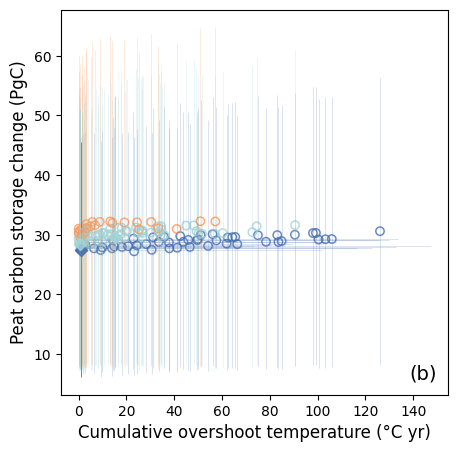

In [24]:
plt.figure(figsize=(5., 5.))
#plt.subplot(2,2,2)
# # plot tier2
for targetT in tgt_lst:
    fig2_plt(ds_calc, targetT,'deltaC','cumT', 'PROVIDE','none')
# plot tier1
#for targetT in ds_calc.target_T.values:
    #fig2_plt(ds_calc_tier1, targetT,'cum_abs_Ept_CO2','cumT', 'Tier1','none')
# plot tier1
for targetT in tgt_lst:
    fig2_plt(ds_calc_ssp, targetT,'deltaC','cumT', 'SSP','none')
#plt.legend()
plt.text(0.9, 0.08, "(b)", transform=plt.gca().transAxes, fontsize = 14,  va='top')
plt.xlabel('Cumulative overshoot temperature (\u00B0C yr)', fontsize = 12)
plt.ylabel('Peat carbon storage change (PgC)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig3_Tcum_cumC.png', dpi = 300, bbox_inches='tight')

### plot 3

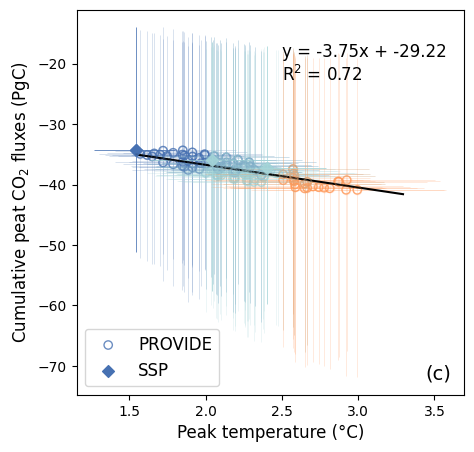

In [34]:
plt.figure(figsize=(5.,5.))
for targetT in tgt_lst:
    fig2_plt(ds_calc, targetT,'cum_abs_Ept_CO2','peakT', 'PROVIDE','shp')
# plot tier1
#for targetT in ds_calc.target_T.values:
    #fig2_plt(ds_calc_tier1, targetT,'cum_abs_Ept_CO2','peakT', 'Tier1','shp')
# plot ssp
for targetT in tgt_lst:
    fig2_plt(ds_calc_ssp, targetT,'cum_abs_Ept_CO2','peakT', 'SSP','shp')

# Linear regression line  ----------------- start --------------------
ds_plt = xr.merge([ds_calc[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']],ds_calc_ssp[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']]])
# find the scenarios where ov_msk_bg is 0 for all target_T values
ov_sum = ds_plt.ov_msk_bg.sum(dim='target_T')
valid_scen = ov_sum.where(ov_sum > 0, drop=True).scen.values
# create a new dataarray x_data that contains only Tpeak_bg for the valid scenarios
x_data = ds_plt.Tpeak_bg.sel(scen=valid_scen)
y_data = ds_plt.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CO2').sel(scen=valid_scen)
# remove NaN and inf values from x and y
valid = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data) | (x_data >= 1e10))
x = x_data[valid]
y = y_data[valid]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
x_values = np.linspace(x.min(), x.max(), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color=col_txt)
# R-squared and equation
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = f'R$^2$ = {r_value**2:.2f}'
# add the text to the plot
#plt.text(0.1, 0.85, f'{equation}\n{r_squared}', fontsize=12, 
         #ha='left', va='center', color='r', transform=plt.transAxes, zorder=10)
plt.text(2.5, -20., f'{equation}\n{r_squared}', fontsize=12, ha='left', va='center', color=col_txt, zorder=10)
# Linear regression line ---------------- end -------------------

plt.legend(fontsize = 12, loc = 'lower left')
plt.text(0.9, 0.08, "(c)", transform=plt.gca().transAxes, fontsize = 14,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Cumulative peat CO$_2$ fluxes (PgC)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig3_Tpeak_cumCO2.png', dpi=300, bbox_inches='tight')

### plot 4

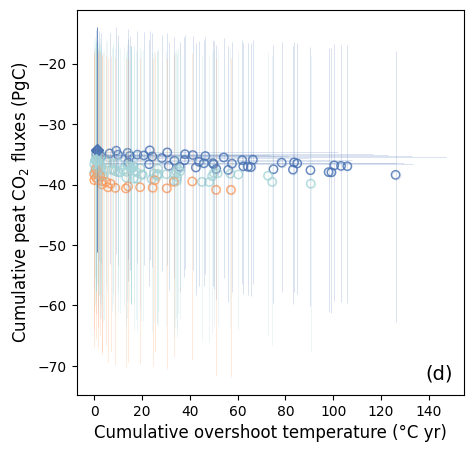

In [35]:
plt.figure(figsize=(5., 5.))
#plt.subplot(2,2,2)
# # plot tier2
for targetT in tgt_lst:
    fig2_plt(ds_calc, targetT,'cum_abs_Ept_CO2','cumT', 'PROVIDE','none')
# plot tier1
#for targetT in ds_calc.target_T.values:
    #fig2_plt(ds_calc_tier1, targetT,'cum_abs_Ept_CO2','cumT', 'Tier1','none')
# plot tier1
for targetT in tgt_lst:
    fig2_plt(ds_calc_ssp, targetT,'cum_abs_Ept_CO2','cumT', 'SSP','none')
#plt.legend()
plt.text(0.9, 0.08, "(d)", transform=plt.gca().transAxes, fontsize = 14,  va='top')
plt.xlabel('Cumulative overshoot temperature (\u00B0C yr)', fontsize = 12)
plt.ylabel('Cumulative peat CO$_2$ fluxes (PgC)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig3_Tcum_cumCO2.png', dpi = 300, bbox_inches='tight')

### plot 5

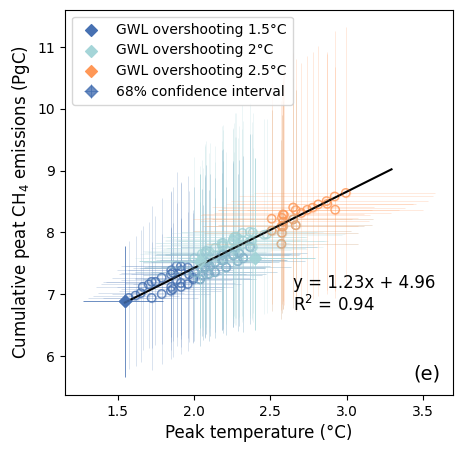

In [38]:
plt.figure(figsize=(5, 5))
# plot tier2
for targetT in tgt_lst:
    fig2_plt(ds_calc, targetT,'cum_abs_Ept_CH4','peakT', 'PROVIDE','none')
# plot tier1
#for targetT in ds_calc.target_T.values:
    #fig2_plt(ds_calc_tier1, targetT,'cum_abs_Ept_CH4','peakT', 'Tier1','colr')
# plot tier1
for targetT in tgt_lst:
    fig2_plt(ds_calc_ssp, targetT,'cum_abs_Ept_CH4','peakT', 'SSP','colr')

# Linear regression line  ----------------- start --------------------
ds_plt = xr.merge([ds_calc[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']],ds_calc_ssp[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']]])
# find the scenarios where ov_msk_bg is 0 for all target_T values
ov_sum = ds_plt.ov_msk_bg.sum(dim='target_T')
valid_scen = ov_sum.where(ov_sum > 0, drop=True).scen.values
# create a new dataarray x_data that contains only Tpeak_bg for the valid scenarios
x_data = ds_plt.Tpeak_bg.sel(scen=valid_scen)
y_data = ds_plt.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').sel(scen=valid_scen)/1000
# remove NaN and inf values from x and y
valid = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data) | (x_data >= 1e10))
x = x_data[valid]
y = y_data[valid]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
x_values = np.linspace(x.min(), x.max(), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color=col_txt)
# R-squared and equation
equation = f'y = {slope:.2f}x + {intercept:.2f}'
r_squared = f'R$^2$ = {r_value**2:.2f}'
# add the text to the plot
#plt.text(0.1, 0.85, f'{equation}\n{r_squared}', fontsize=12, 
         #ha='left', va='center', color='r', transform=plt.transAxes, zorder=10)
plt.text(2.65, 7, f'{equation}\n{r_squared}', fontsize=12, ha='left', va='center', color=col_txt, zorder=10)
# Linear regression line ---------------- end -------------------
#plt.legend(fontsize = 10, loc='upper left', frameon=False)
plt.legend(fontsize = 10, loc='upper left')
plt.text(0.9, 0.08, "(e)", transform=plt.gca().transAxes, fontsize = 14,  va='top')
plt.xlabel('Peak temperature (\u00B0C)', fontsize = 12)
plt.ylabel('Cumulative peat CH$_4$ emissions (PgC)', fontsize = 12)
plt.savefig(path_fig+'/sub_fig3_Tpeak_cumCH4.png', dpi=300, bbox_inches='tight')

### plot 6

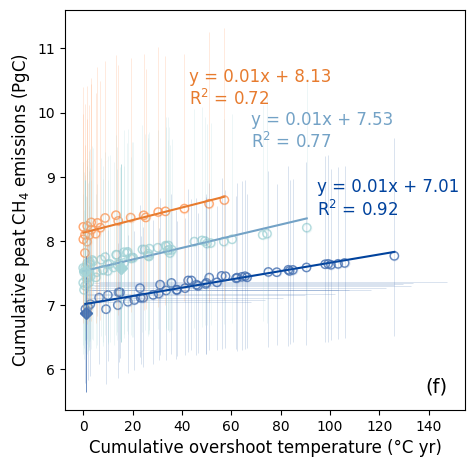

In [39]:
plt.figure(figsize=(5, 5))
# plot tier2
for targetT in tgt_lst:
    fig2_plt(ds_calc, targetT,'cum_abs_Ept_CH4','cumT', 'PROVIDE','none')
# plot tier1
#for targetT in ds_calc.target_T.values:
    #fig2_plt(ds_calc_tier1, targetT,'cum_abs_Ept_CH4','cumT', 'Tier1','none')
# plot tier1
for targetT in tgt_lst:
    fig2_plt(ds_calc_ssp, targetT,'cum_abs_Ept_CH4','cumT', 'SSP','none')
#plt.legend()
plt.text(0.9, 0.08, "(f)", transform=plt.gca().transAxes, fontsize = 14,  va='top')

# Linear regression line  ----------------- start --------------------
for targetT in tgt_lst:
    ds_plt = xr.merge([ds_calc[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']],ds_calc_ssp[['Tpeak_bg','cumT_bg','best_guess_cum','ov_msk_bg']]]).sel(target_T=targetT)
    # find the scenarios where ov_msk_bg is 0 for all target_T values
    ov_sum = ds_plt.ov_msk_bg
    valid_scen = ov_sum.where(ov_sum > 0, drop=True).scen.values
    # create a new dataarray x_data that contains only Tpeak_bg for the valid scenarios
    x_data = ds_plt.cumT_bg.sel(scen=valid_scen)
    y_data = ds_plt.best_guess_cum.sel(var_name_cum = 'cum_abs_Ept_CH4').sel(scen=valid_scen)/1000
    # remove NaN and inf values from x and y
    valid = ~(np.isnan(x_data) | np.isnan(y_data) | np.isinf(x_data) | np.isinf(y_data) | (x_data >= 1e10))
    x = x_data[valid]
    y = y_data[valid]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    x_values = np.linspace(x.min(), x.max(), 100)
    y_values = slope * x_values + intercept
    plt.plot(x_values, y_values, color=col_txt_dsk[targetT])
    # R-squared and equation
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    r_squared = f'R$^2$ = {r_value**2:.2f}'
    # add the text to the plot
    #plt.text(0.1, 0.85, f'{equation}\n{r_squared}', fontsize=12, 
            #ha='left', va='center', color='r', transform=plt.transAxes, zorder=10)
    plt.text(x_values.max()*0.75, y_values.max()*2-7, f'{equation}\n{r_squared}', fontsize=12, ha='left', va='center', color=col_txt_dsk[targetT], zorder=10)
# Linear regression line ---------------- end -------------------

plt.xlabel('Cumulative overshoot temperature (\u00B0C yr)', fontsize = 12)
plt.ylabel('Cumulative peat CH$_4$ emissions (PgC)', fontsize = 12)

#plt.savefig(folder_fig+'Tcum_cumCH4_errorbar_reduced_one.png')
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.17, wspace=0.2)
plt.savefig(path_fig+'/sub_fig3_Tcum_cumCH4.png', dpi=300, bbox_inches='tight')

## Combine plots

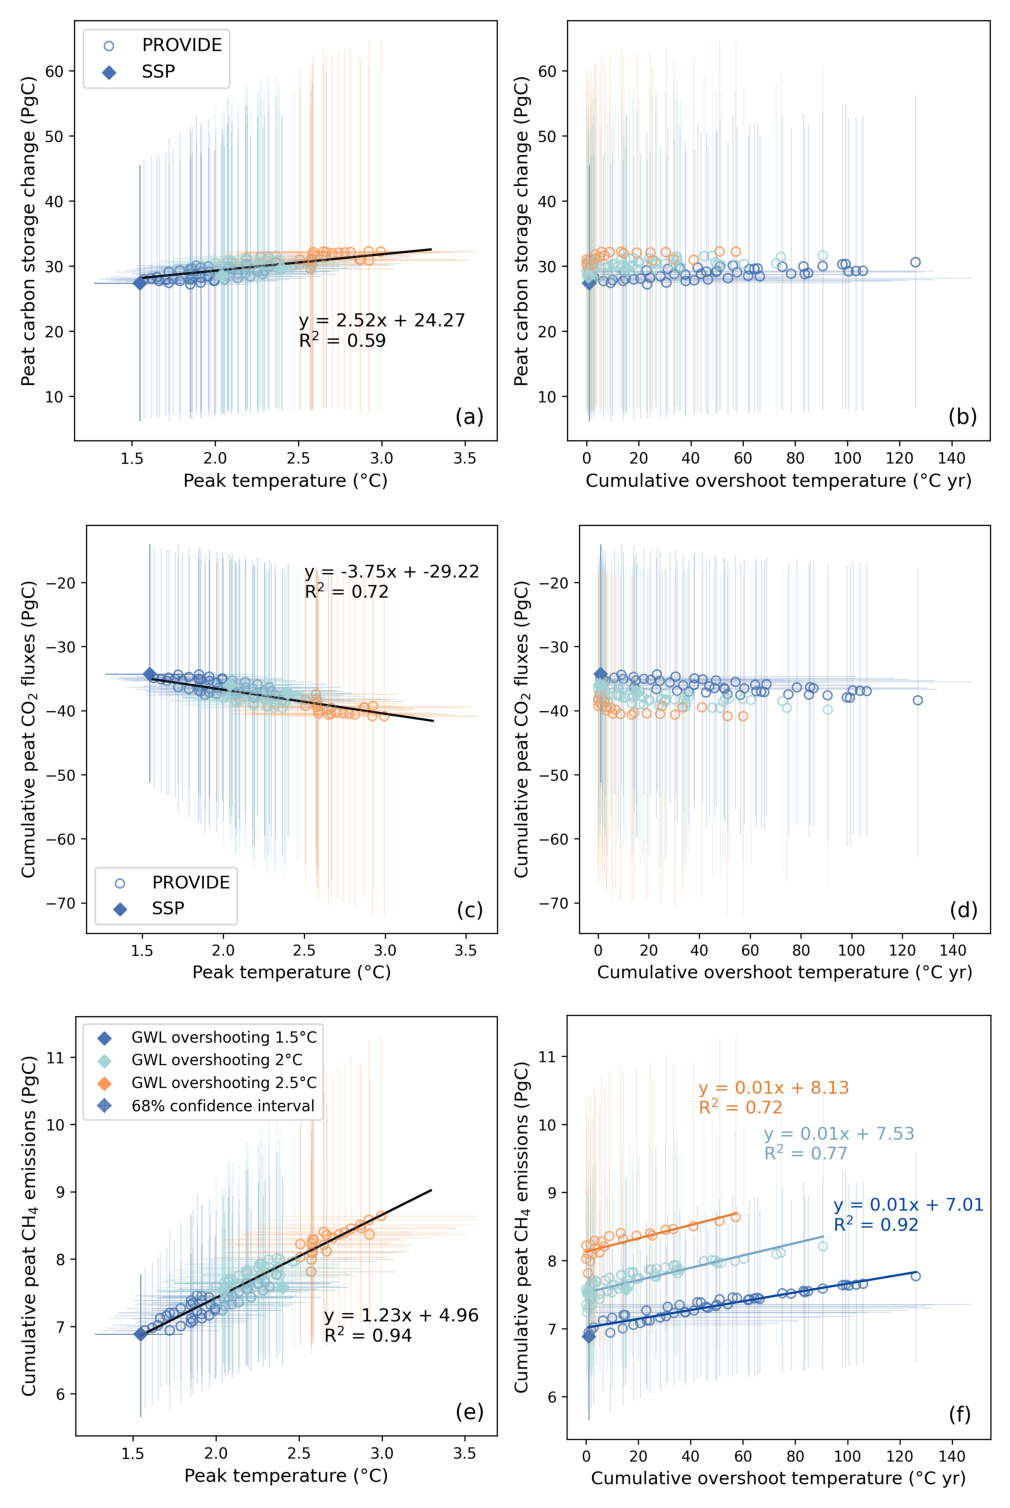

In [40]:
from PIL import Image

# Load the four PNG images
img1 = Image.open(path_fig + '/sub_fig3_Tpeak_cumCO2.png')
img2 = Image.open(path_fig + '/sub_fig3_Tcum_cumCO2.png')
img3 = Image.open(path_fig + '/sub_fig3_Tpeak_cumCH4.png')
img4 = Image.open(path_fig + '/sub_fig3_Tcum_cumCH4.png')
img5 = Image.open(path_fig + '/sub_fig3_Tpeak_cumC.png')
img6 = Image.open(path_fig + '/sub_fig3_Tcum_cumC.png')

# Set the figure size
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# Load each image into the corresponding subplot
axes[0, 0].imshow(img5)
axes[0, 1].imshow(img6)
axes[1, 0].imshow(img1)
axes[1, 1].imshow(img2)
axes[2, 0].imshow(img3)
axes[2, 1].imshow(img4)

# Set the axis labels to off for all subplots
for ax in axes.flat:
    ax.set_axis_off()

# Set the spacing between subplots to 0
fig.subplots_adjust( top = 1, bottom = 0,left=0.02, right=1.01, hspace=-0.01, wspace=-0.01)
## Save to PNG
plt.savefig(path_fig+'/figure3.png', dpi=300, bbox_inches='tight')
## Save to PDF
plt.savefig(path_fig+'/figure3.pdf', dpi=300, bbox_inches='tight')